In [1]:
import numpy as np
import numpy.random as rn
import pandas as pd

from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

# import NMF from sklearn
from sklearn.decomposition import NMF

import matplotlib.pyplot as plt
import seaborn as sns

from path import Path

from tqdm.notebook import tqdm

In [2]:
# sometimes use all-caps to denote global variables
DATA_SUPDIR = Path('/net/projects/schein-lab/jshou/dat/')

def load_team_data(team, dat_supdir=DATA_SUPDIR, return_split=False):
    # load data
    train_pivot = pd.read_csv(dat_supdir.joinpath(team, 'train_pivot.csv'), index_col=0)
    test_pivot = pd.read_csv(dat_supdir.joinpath(team, 'test_pivot.csv'), index_col=0)

    # create a single pivot table for all outcomes
    total_pivot = pd.concat([train_pivot, test_pivot], axis=0)

    # this is a (timestep x county)-array of all outcomes
    all_outcomes_TN = total_pivot.values
    n_timesteps, n_counties = all_outcomes_TN.shape

    # names of the dates and counties
    dates = total_pivot.index
    county_names = total_pivot.columns

    # make sure that the last county is the stadium county
    assert county_names[-1] == 'Stadium_County'

    # the index of the intervention time
    intervention_t = train_pivot.values.shape[0]

    # make sure that the intervention time is correct
    assert np.allclose(all_outcomes_TN[:intervention_t], train_pivot.values)
    assert np.allclose(all_outcomes_TN[intervention_t:], test_pivot.values)
    
    if not return_split:
        return total_pivot, intervention_t
    else:
        return total_pivot, intervention_t, train_pivot, test_pivot

TEAM = 'Indianapolis'
total_pivot, intervention_t = load_team_data(TEAM)
all_outcomes_TN = total_pivot.values
n_timesteps, n_counties = all_outcomes_TN.shape

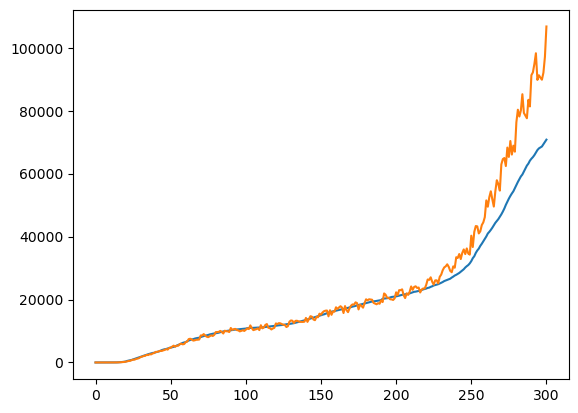

In [3]:
def create_semi_synthetic_matrix(all_outcomes_TN, intervention_t, alpha=500, latent_dim=10, seed=617, model_mismatch_p=0.0):
    n_timesteps, n_counties = all_outcomes_TN.shape

    # fit NMF to the training data
    nmf = NMF(n_components=latent_dim, init='random', random_state=seed, max_iter=5000)
    W_TK = nmf.fit_transform(all_outcomes_TN)
    H_KN = nmf.components_

    Mu_TN = W_TK @ H_KN

    def last_digit(x):
        return int(str(x)[-1])

    rn.seed(seed)
    synth_all_outcomes_TN = rn.poisson(Mu_TN)
    if model_mismatch_p > 0.0:
        for t in range(1, n_timesteps):
            innovation_t = 0.9 + rn.beta(1 + 2 * int(last_digit(t) < 5), 1 + 2 * int(last_digit(t) >= 5)) * 0.2  # always between [0.9, 1.1]
            Mu_TN[t] = (1-model_mismatch_p) * Mu_TN[t] + model_mismatch_p * (synth_all_outcomes_TN[t-1] * innovation_t)

    true_counterfactuals = Mu_TN[intervention_t:, -1].copy()
    Mu_TN[intervention_t:, -1] *= (1 + np.log1p(np.arange(n_timesteps - intervention_t))) ** (np.arange(n_timesteps - intervention_t)/alpha)
    return rn.poisson(Mu_TN), Mu_TN, true_counterfactuals

synth_all_outcomes_TN, Mu_TN, true_counterfactuals = create_semi_synthetic_matrix(all_outcomes_TN, intervention_t, alpha=500, seed=617, model_mismatch_p=0.75)

plt.plot(all_outcomes_TN[:, -1])
plt.plot(synth_all_outcomes_TN[:, -1])


In [16]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

SYNTH_DATA_SUPDIR = Path('/net/projects/schein-lab/jshou/synth_dat/new_dat_nov_20_2023')

for team_dir in tqdm(DATA_SUPDIR.dirs()):
    team = team_dir.basename()

    total_pivot, intervention_t = load_team_data(team)
    all_outcomes_TN = total_pivot.values
    n_timesteps, n_counties = all_outcomes_TN.shape

    for s in [25, 100, intervention_t]:
        outcomes_TN = all_outcomes_TN[intervention_t-s:]
        
        for model_mismatch_p in [0, 50, 100]:
            for alpha in [250, 500, 100000]:
                for seed in [617, 781]:
                    synth_outcomes_TN, Mu_TN, true_counterfactuals = create_semi_synthetic_matrix(all_outcomes_TN=outcomes_TN, 
                                                                                                  intervention_t=s, 
                                                                                                  alpha=alpha, 
                                                                                                  seed=seed, 
                                                                                                  latent_dim=10,
                                                                                                  model_mismatch_p=model_mismatch_p/100.)
                    # set the values of the pandas dataframe
                    synth_total_pivot = total_pivot.iloc[intervention_t-s:,:].copy()
                    synth_total_pivot.iloc[:,:] = synth_outcomes_TN
                    assert np.allclose(synth_total_pivot.values, synth_outcomes_TN)

                    out_dir = SYNTH_DATA_SUPDIR.joinpath(team, 
                                                         f's_{s}' if s in [25, 50, 100] else 's_all',
                                                         f'model_mismatch_p_{model_mismatch_p}', 
                                                         f'alpha_{alpha}', 
                                                         f'seed_{seed}')
                    out_dir.makedirs_p()

                    synth_total_pivot.iloc[:s].to_csv(out_dir.joinpath('train_pivot.csv'))
                    synth_total_pivot.iloc[s:].to_csv(out_dir.joinpath('test_pivot.csv'))

                    np.savez_compressed(out_dir.joinpath('ground_truth_rates.npz'), Mu_TN=Mu_TN, true_counterfactuals=true_counterfactuals)
                

  0%|          | 0/31 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Analyze results

In [3]:
def get_reg_arrays(Z, all_outcomes_TN, intervention_t, counterfactual=False, include_previous_outcome=False):
    latent_dim, n_counties = Z.shape
    assert all_outcomes_TN.shape[1] == n_counties
    all_outcomes_NT = all_outcomes_TN.T

    A = np.zeros((n_counties, 1))
    if not counterfactual:
        A[-1] = 1
    
    if include_previous_outcome:
        # Y_{i,t} ~ A + Z_i + Y_{i,-1} 
        B = np.array(all_outcomes_NT[:, intervention_t-1])[:, np.newaxis]
        X = np.concatenate([Z.T, B, A], axis=1)
        assert X.shape == (n_counties, latent_dim + 2)
    else:
        X = np.concatenate([Z.T, A], axis=1)
        assert X.shape == (n_counties, latent_dim + 1)

    Y = np.array(all_outcomes_NT[:, intervention_t:])
    return X, Y


def get_counterfactual_from_best_reg(Z, all_outcomes_TN, intervention_t, include_previous_outcome=True,
                                     reg_type='Ridge', reg_params={"alpha": [0, 1e-4,1e-3, 1e-2]}):
    
    X, Y = get_reg_arrays(Z, all_outcomes_TN, intervention_t, include_previous_outcome=include_previous_outcome)

    if reg_type == 'Ridge':
        reg = Ridge()
    elif reg_type == 'MLP': 
        reg = MLPRegressor(hidden_layer_sizes=(20, 20), max_iter=5000)
    elif reg_type == 'Lasso':
        reg = Lasso()
    
    cv = GridSearchCV(reg, reg_params, scoring='r2', cv=5)
    cv_results = cv.fit(X, Y)
    best_reg = cv_results.best_estimator_

    X, _ = get_reg_arrays(Z, all_outcomes_TN, intervention_t, include_previous_outcome=include_previous_outcome, counterfactual=True)
    return best_reg.predict(X)[-1], best_reg  # return only affected county and model


In [5]:
SYNTH_SUPDIR = Path('/net/projects/schein-lab/jshou/synth_dat/new_dat_nov_20_2023')

# find posterior_sample_file
posterior_sample_files = list(SYNTH_SUPDIR.walkfiles('*posterior_samples.npz'))
for posterior_sample_file in tqdm(posterior_sample_files):
    if posterior_sample_file.parent.joinpath('counterfactuals.npy').exists():
        continue

    posterior_samples = np.load(posterior_sample_file)
    Z_samples = posterior_samples['Z']

    # walk back up the path to get the data
    synth_data_dir = posterior_sample_file.parent
    while synth_data_dir.basename() != 'synth_dat':
        if synth_data_dir.joinpath('train_pivot.csv').exists():
            break
        synth_data_dir = synth_data_dir.parent

    # load the data
    train_pivot = pd.read_csv(synth_data_dir.joinpath('train_pivot.csv'), index_col=0)
    test_pivot = pd.read_csv(synth_data_dir.joinpath('test_pivot.csv'), index_col=0)
    total_pivot = pd.concat([train_pivot, test_pivot], axis=0)
    all_outcomes_TN = total_pivot.values
    n_timesteps, n_counties = all_outcomes_TN.shape
    intervention_t = train_pivot.values.shape[0]
    true_counterfactuals = np.load(synth_data_dir.joinpath('ground_truth_rates.npz'))['true_counterfactuals']

    # get team name, model, etc from path
    subdirs = synth_data_dir.splitall()
    seed = int(subdirs[-1].split('_')[-1])
    alpha = int(subdirs[-2].split('_')[-1])
    model_mismatch_p = int(subdirs[-3].split('_')[-1])/100.
    team = subdirs[-4]

    # compute counterfactuals for every posterior sample using Ridge regression
    reg_type = 'Ridge'
    include_previous_outcome = True

    counterfactual_preds = []
    for Z in tqdm(Z_samples):
        cf_pred, best_reg = get_counterfactual_from_best_reg(Z,
                                                             reg_type=reg_type,
                                                             all_outcomes_TN=all_outcomes_TN, 
                                                             intervention_t=intervention_t, 
                                                             include_previous_outcome=include_previous_outcome)
        counterfactual_preds.append(cf_pred)
    counterfactual_preds = np.array(counterfactual_preds)
    np.save(posterior_sample_file.parent.joinpath('counterfactuals.npy'), counterfactual_preds)

  0%|          | 0/1936 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [6]:

SYNTH_SUPDIR = Path('/net/projects/schein-lab/jshou/synth_dat')
counterfactual_files = list(SYNTH_SUPDIR.walkfiles('*counterfactuals.npy'))

rows = []
for counterfactual_file in tqdm(counterfactual_files):
    counterfactual_preds = np.load(counterfactual_file)

    # walk back up the path to get the data
    synth_data_dir = counterfactual_file.parent
    while synth_data_dir.basename() != 'synth_dat':
        if synth_data_dir.joinpath('train_pivot.csv').exists():
            break
        synth_data_dir = synth_data_dir.parent

    # load the data
    train_pivot = pd.read_csv(synth_data_dir.joinpath('train_pivot.csv'), index_col=0)
    test_pivot = pd.read_csv(synth_data_dir.joinpath('test_pivot.csv'), index_col=0)
    total_pivot = pd.concat([train_pivot, test_pivot], axis=0)
    all_outcomes_TN = total_pivot.values
    n_timesteps, n_counties = all_outcomes_TN.shape
    intervention_t = train_pivot.values.shape[0]
    true_counterfactuals = np.load(synth_data_dir.joinpath('ground_truth_rates.npz'))['true_counterfactuals']

    # get team name, model, etc from path
    subdirs = synth_data_dir.splitall()
    seed = int(subdirs[-1].split('_')[-1])
    alpha = int(subdirs[-2].split('_')[-1])
    model_mismatch_p = int(subdirs[-3].split('_')[-1])/100.
    team = subdirs[-4]

    errors = np.abs(counterfactual_preds - true_counterfactuals) / true_counterfactuals

    percentiles = [10, 25, 50, 75, 90]

    for t in range(errors.shape[1]):
        errors_S = errors[:, t]
        error_percentiles = [np.percentile(errors_S, pct, axis=0) for pct in percentiles]
        error_mean = errors_S.mean(axis=0)
        error_std = errors_S.std(axis=0)
        row = (team, alpha, model_mismatch_p, t) + tuple(error_percentiles) + (error_mean, error_std)
        rows.append(row)

errors_df = pd.DataFrame(rows, columns=['team', 'alpha', 'model_mismatch_p', 'days_after_intervention'] + [f'err_{pct}_pct' for pct in percentiles] + ['err_mean', 'err_std'])
errors_df.to_csv(SYNTH_SUPDIR.joinpath('counterfactual_errors.csv'), index=False)

  0%|          | 0/1936 [00:00<?, ?it/s]

In [8]:
errors_df.to_csv(SYNTH_SUPDIR.joinpath('counterfactual_errors.csv'), index=False)
errors_df = pd.read_csv(SYNTH_SUPDIR.joinpath('counterfactual_errors.csv'))
errors_df

,team,alpha,model_mismatch_p,days_after_intervention,err_10_pct,err_25_pct,err_50_pct,err_75_pct,err_90_pct,err_mean,err_std
0,s_100,100000,0.5,0,0.001589,0.004448,0.009229,0.015402,0.053918,0.018298,0.023808
1,s_100,100000,0.5,1,0.000545,0.001329,0.002768,0.005717,0.019081,0.006696,0.011214
2,s_100,100000,0.5,2,0.000950,0.002374,0.005159,0.010198,0.041961,0.013007,0.018952
3,s_100,100000,0.5,3,0.000667,0.001739,0.003661,0.007240,0.030972,0.009512,0.014469
4,s_100,100000,0.5,4,0.002038,0.004152,0.006600,0.009097,0.013904,0.008057,0.007489
...,...,...,...,...,...,...,...,...,...,...,...
158523,s_100,500,0.0,105,0.070521,0.095364,0.125789,0.160946,0.195147,0.129495,0.047833
158524,s_100,500,0.0,106,0.068164,0.093048,0.124616,0.160393,0.193623,0.128115,0.048761
158525,s_100,500,0.0,107,0.064159,0.088141,0.119978,0.155184,0.189535,0.123453,0.048310
158526,s_100,500,0.0,108,0.070091,0.094093,0.124575,0.160034,0.193410,0.128376,0.047825


Text(0.5, 1.0, '')

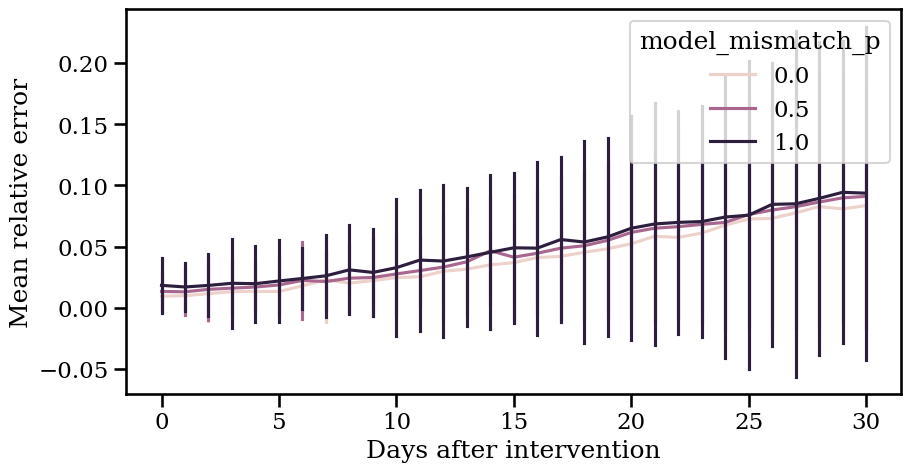

In [9]:
sns.set_context('talk')
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'

# lineplot of error over time
plt.figure(figsize=(10, 5))
sns.lineplot(data=errors_df[(errors_df['days_after_intervention'] <= 30) & 
                            (errors_df['alpha'] == 500) & 
                            (errors_df['model_mismatch_p'].isin([0.0, 0.5, 1.0]))], 
             x='days_after_intervention', 
             y='err_mean', 
            #  y_err='err_std',
            #  hue='alpha', 
             hue='model_mismatch_p', 
             errorbar='sd',
             err_style="bars"
             )

plt.ylabel('Mean relative error')
plt.xlabel('Days after intervention')

plt.title('')

# set errorbars manually
# plt.errorbar(x=errors_df[(errors_df['team']=='Minnesota') &
#                             (errors_df['alpha']==250) &
#                             (errors_df['days_after_intervention'] <= 40)]['days_after_intervention'],
#                 y=errors_df[(errors_df['team']=='Minnesota') &
#                             (errors_df['alpha']==250) &
#                             (errors_df['days_after_intervention'] <= 40)]['err_mean'],
#                 yerr=errors_df[(errors_df['team']=='Minnesota') &
#                             (errors_df['alpha']==250) &
#                             (errors_df['days_after_intervention'] <= 40)]['err_std'],
#                 fmt='none', color='black', capsize=5, capthick=2, zorder=10)


In [4]:
# import mdates
import matplotlib.dates as mdates
import matplotlib.ticker as ticker


def plot_counterfactual_trajectories(total_pivot, intervention_t, counterfactual_preds, rsc_test_pred, team, fig_path=None):
    all_outcomes_TN = total_pivot.values
    dates = pd.to_datetime(total_pivot.index)

    plt.plot(dates, all_outcomes_TN[:, -1], color='orange', lw=3, label='Factual')
    plt.axvline(dates[intervention_t], color='k', lw=1, linestyle='-', label='Day of intervention')
    
    # Compute percentiles and median across trajectories for each time point
    lower_bound = np.percentile(counterfactual_preds, 5, axis=0)
    upper_bound = np.percentile(counterfactual_preds, 95, axis=0)
    median_trajectory = np.median(counterfactual_preds, axis=0)

    post_dates = dates[intervention_t:]
    plt.fill_between(post_dates, lower_bound, upper_bound, color='blue', alpha=0.1, label='90% posterior credible interval')
    plt.plot(post_dates, median_trajectory, color='blue', linestyle=':', lw=3, label='Posterior median counterfactual')
    plt.plot(post_dates, rsc_test_pred, color='green', linestyle='--', lw=3, label='Robust SC counterfactual')
    plt.legend(fontsize=13)
    plt.title(team, fontsize=17)
    plt.xlabel('Day', fontsize=13)

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 3, 5, 7, 9, 11]))  # Every month
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Month and year
    # Format y-ticks to show 'K' for thousands
    def thousands_formatter(x, pos):
        return '%1.0fK' % (x*1e-3)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylabel('Number of new COVID-19 cases', fontsize=13)

    plt.gcf().set_size_inches(10, 6)  # Set the figure size (width, height)
    plt.tight_layout() 
    if fig_path is not None:
        plt.savefig(fig_path, format='pdf', dpi=1000)
        plt.close()
    else:
        plt.show()

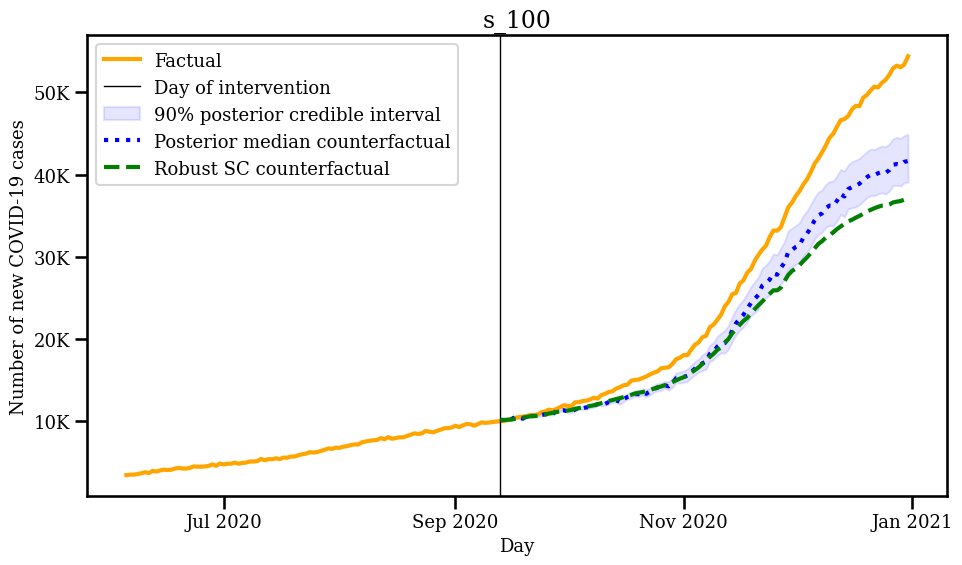

In [11]:
plot_counterfactual_trajectories(total_pivot, 
                                 intervention_t, 
                                 counterfactual_preds, 
                                 true_counterfactuals, 
                                 team, 
                                 fig_path=None)


## New data (which varies the number of pre-intervention outcomes)

In [5]:

SYNTH_SUPDIR = Path('/net/projects/schein-lab/jshou/synth_dat/new_dat_nov_20_2023')
counterfactual_files = list(SYNTH_SUPDIR.walkfiles('*counterfactuals.npy'))

rows = []
for counterfactual_file in tqdm(counterfactual_files):
    counterfactual_preds = np.load(counterfactual_file)

    # walk back up the path to get the data
    synth_data_dir = counterfactual_file.parent
    while synth_data_dir.basename() != 'synth_dat':
        if synth_data_dir.joinpath('train_pivot.csv').exists():
            break
        synth_data_dir = synth_data_dir.parent

    # load the data
    train_pivot = pd.read_csv(synth_data_dir.joinpath('train_pivot.csv'), index_col=0)
    test_pivot = pd.read_csv(synth_data_dir.joinpath('test_pivot.csv'), index_col=0)
    total_pivot = pd.concat([train_pivot, test_pivot], axis=0)
    all_outcomes_TN = total_pivot.values
    n_timesteps, n_counties = all_outcomes_TN.shape
    intervention_t = train_pivot.values.shape[0]
    true_counterfactuals = np.load(synth_data_dir.joinpath('ground_truth_rates.npz'))['true_counterfactuals']

    # get team name, model, etc from path
    subdirs = counterfactual_file.parent.splitall()
    model_seed = int(subdirs[-1].split('_')[-1])
    latent_dim = int(subdirs[-2].split('_')[-1])
    model = subdirs[-3]
    data_seed = int(subdirs[-5].split('_')[-1])
    alpha = int(subdirs[-6].split('_')[-1])
    model_mismatch_p = int(subdirs[-7].split('_')[-1])/100.
    s = subdirs[-8].split('_')[-1]
    team = subdirs[-9]

    if counterfactual_preds.ndim == 2:
        counterfactual_preds = counterfactual_preds.mean(axis=0)
    
    rel_err_T = np.abs(counterfactual_preds - true_counterfactuals) / true_counterfactuals
    squ_err_T = (counterfactual_preds - true_counterfactuals) ** 2
    percentiles = [10, 25, 50, 75, 90]

    for t in range(rel_err_T.size):
        mre = rel_err_T[t]
        mse = squ_err_T[t]
        row = (team, alpha, model_mismatch_p, s, data_seed, model, model_seed, latent_dim, t, mre, mse)
        rows.append(row)

    ####
    # only works for posterior samples
    ###
    # errors = np.abs(counterfactual_preds - true_counterfactuals) / true_counterfactuals
    # percentiles = [10, 25, 50, 75, 90]

    # for t in range(errors.shape[1]):
    #     errors_S = errors[:, t]
    #     error_percentiles = [np.percentile(errors_S, pct, axis=0) for pct in percentiles]
    #     error_mean = errors_S.mean(axis=0)
    #     error_std = errors_S.std(axis=0)
    #     row = (team, alpha, model_mismatch_p, s, data_seed, model, model_seed, latent_dim, t) + tuple(error_percentiles) + (error_mean, error_std)
    #     rows.append(row)
    
# errors_df = pd.DataFrame(rows, columns=['team', 'alpha', 'model_mismatch_p', 's', 'data_seed', 'model', 'model_seed', 'latent_dim', 'days_after_intervention'] + [f'err_{pct}_pct' for pct in percentiles] + ['err_mean', 'err_std'])
errors_df = pd.DataFrame(rows, columns=['team', 'alpha', 'model_mismatch_p', 's', 'data_seed', 'model', 'model_seed', 'latent_dim', 'days_after_intervention'] + ['mre', 'mse'])
errors_df.to_csv(SYNTH_SUPDIR.joinpath('counterfactual_errors.csv'), index=False)

  0%|          | 0/2422 [00:00<?, ?it/s]

In [7]:
team_intervention_t_dict = {}
for counterfactual_file in tqdm(counterfactual_files):
    # get team name, model, etc from path
    subdirs = counterfactual_file.parent.splitall()
    team = subdirs[-9]
    if team in team_intervention_t_dict:
        continue

    # walk back up the path to get the data
    synth_data_dir = counterfactual_file.parent
    while synth_data_dir.basename() != 'synth_dat':
        if synth_data_dir.joinpath('train_pivot.csv').exists():
            break
        synth_data_dir = synth_data_dir.parent

    # load the data
    train_pivot = pd.read_csv(synth_data_dir.joinpath('train_pivot.csv'), index_col=0)
    intervention_t = train_pivot.values.shape[0]
    team_intervention_t_dict[team] = intervention_t

for team in team_intervention_t_dict.keys():
    errors_df.loc[errors_df['team'] == team, 'intervention_t'] = team_intervention_t_dict[team]

errors_df['n_pre'] = errors_df['s'].copy()
errors_df.loc[errors_df['n_pre']=='all', 'n_pre'] = errors_df['intervention_t']
errors_df['n_pre'] = errors_df['n_pre'].astype(int)

errors_df.to_csv(SYNTH_SUPDIR.joinpath('counterfactual_errors.csv'), index=False)

  0%|          | 0/2422 [00:00<?, ?it/s]

In [8]:
# SYNTH_SUPDIR = Path('/net/projects/schein-lab/jshou/synth_dat/new_dat_nov_20_2023')
# counterfactual_files = list(SYNTH_SUPDIR.walkfiles('*counterfactuals.npy'))
# errors_df = pd.read_csv(SYNTH_SUPDIR.joinpath('counterfactual_errors.csv'), low_memory=False)
errors_df

,team,alpha,model_mismatch_p,s,data_seed,model,model_seed,latent_dim,days_after_intervention,mre,mse,intervention_t,n_pre
0,Baltimore,100000,0.5,100,781,GAP,617,10,0,0.018085,5.122052e+05,100.0,100
1,Baltimore,100000,0.5,100,781,GAP,617,10,1,0.004933,3.943751e+04,100.0,100
2,Baltimore,100000,0.5,100,781,GAP,617,10,2,0.012118,2.537303e+05,100.0,100
3,Baltimore,100000,0.5,100,781,GAP,617,10,3,0.006455,7.001389e+04,100.0,100
4,Baltimore,100000,0.5,100,781,GAP,617,10,4,0.003562,2.258714e+04,100.0,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...
198375,Minnesota,500,0.0,100,781,GAP,617,5,105,0.129484,2.245446e+07,25.0,100
198376,Minnesota,500,0.0,100,781,GAP,617,5,106,0.128091,2.209666e+07,25.0,100
198377,Minnesota,500,0.0,100,781,GAP,617,5,107,0.123421,2.059911e+07,25.0,100
198378,Minnesota,500,0.0,100,781,GAP,617,5,108,0.128357,2.248077e+07,25.0,100


/home/schein/Synthetic-Control-Paper-Model/fig/semi_synthetic_alpha_250_latent_dim_10.pdf
/home/schein/Synthetic-Control-Paper-Model/fig/semi_synthetic_alpha_500_latent_dim_10.pdf
/home/schein/Synthetic-Control-Paper-Model/fig/semi_synthetic_alpha_100000_latent_dim_10.pdf


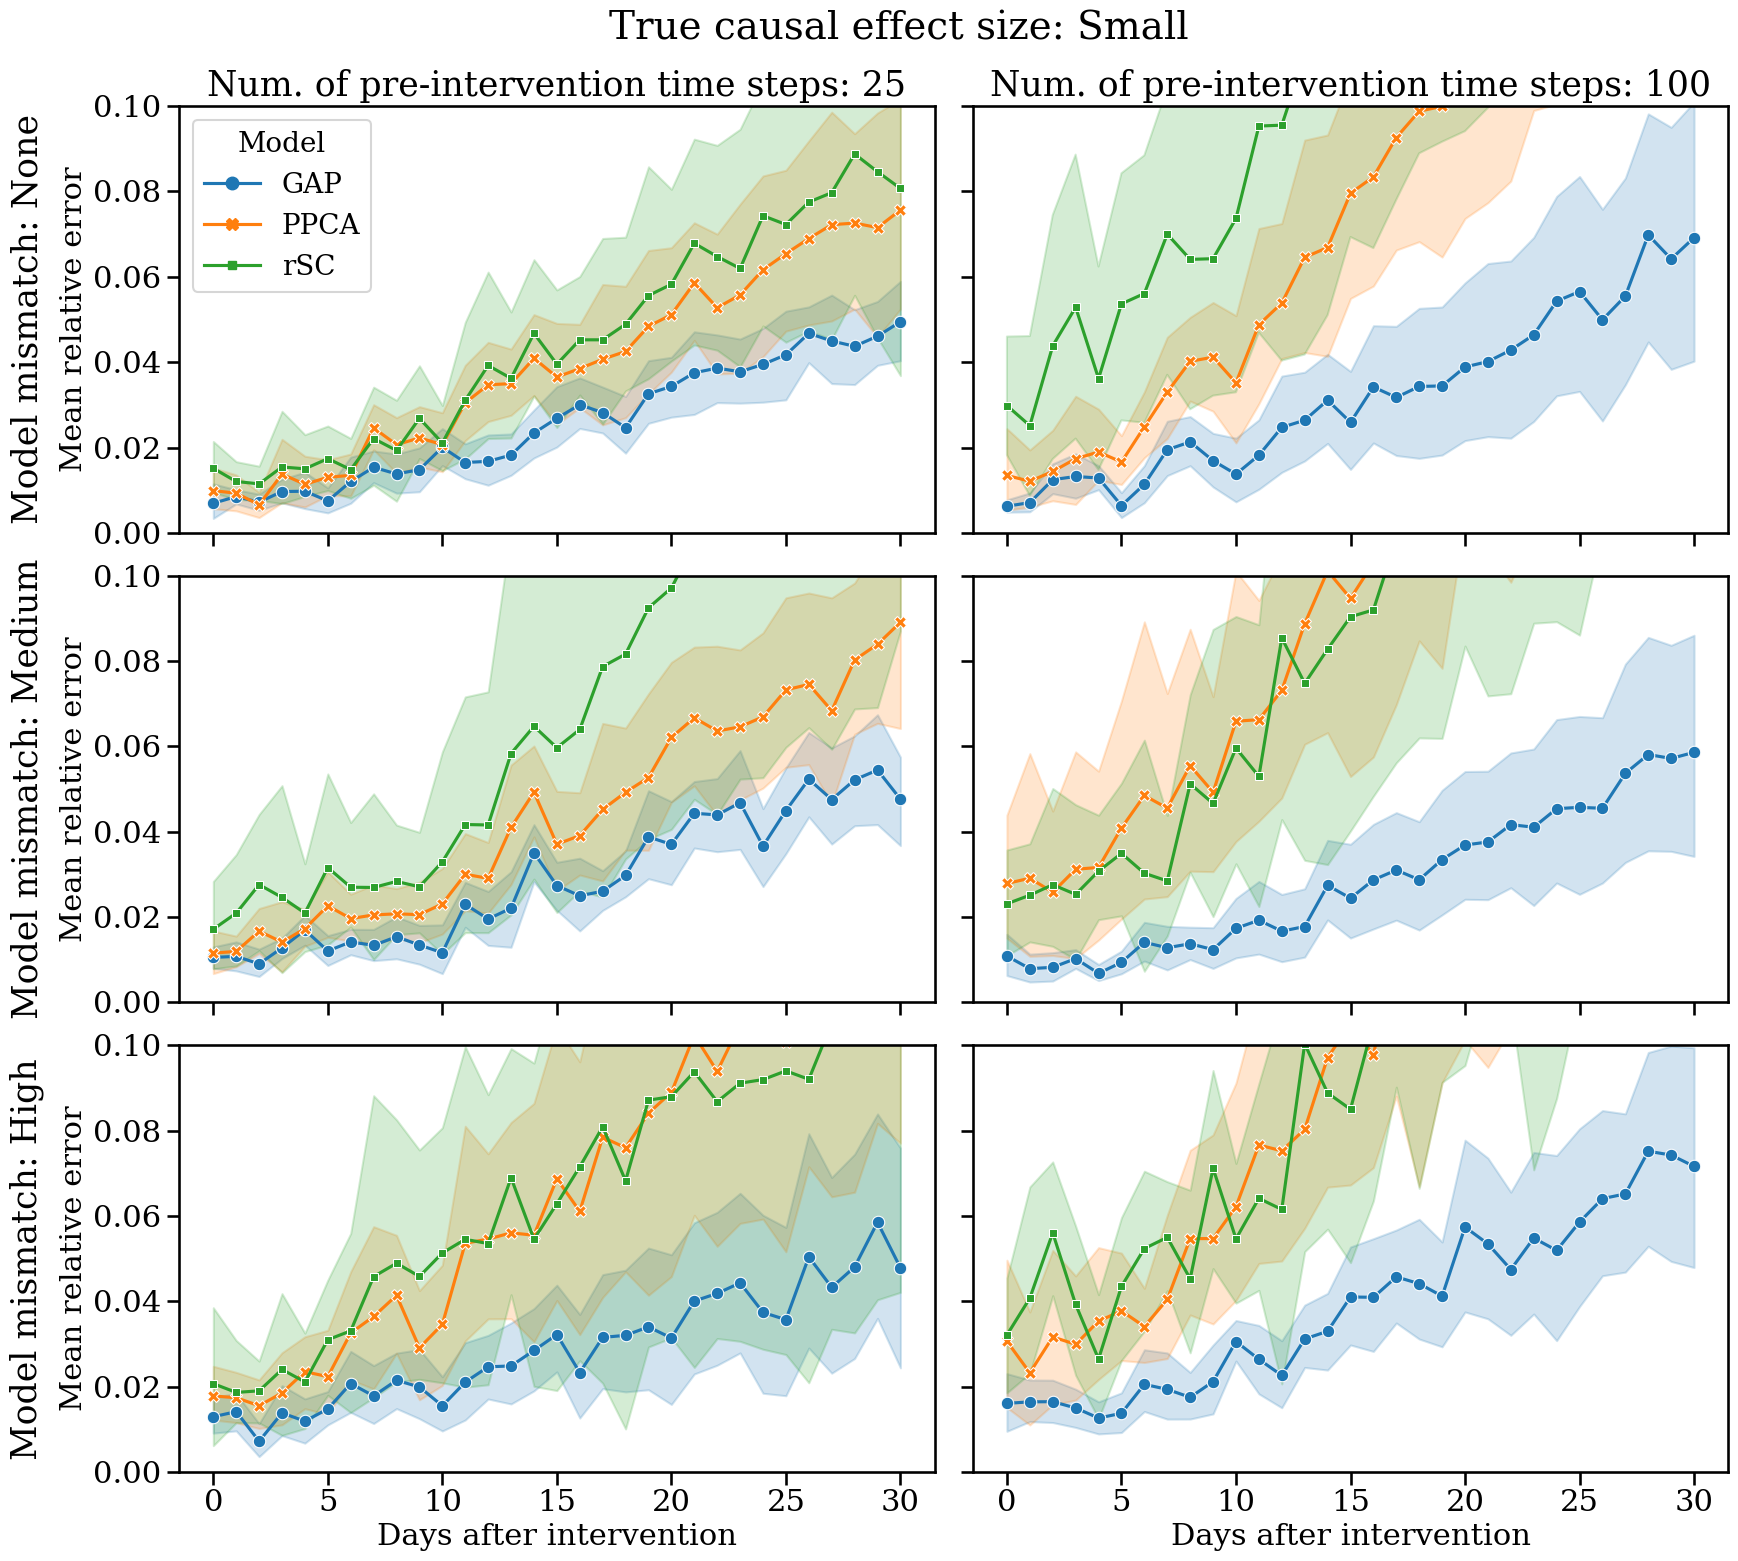

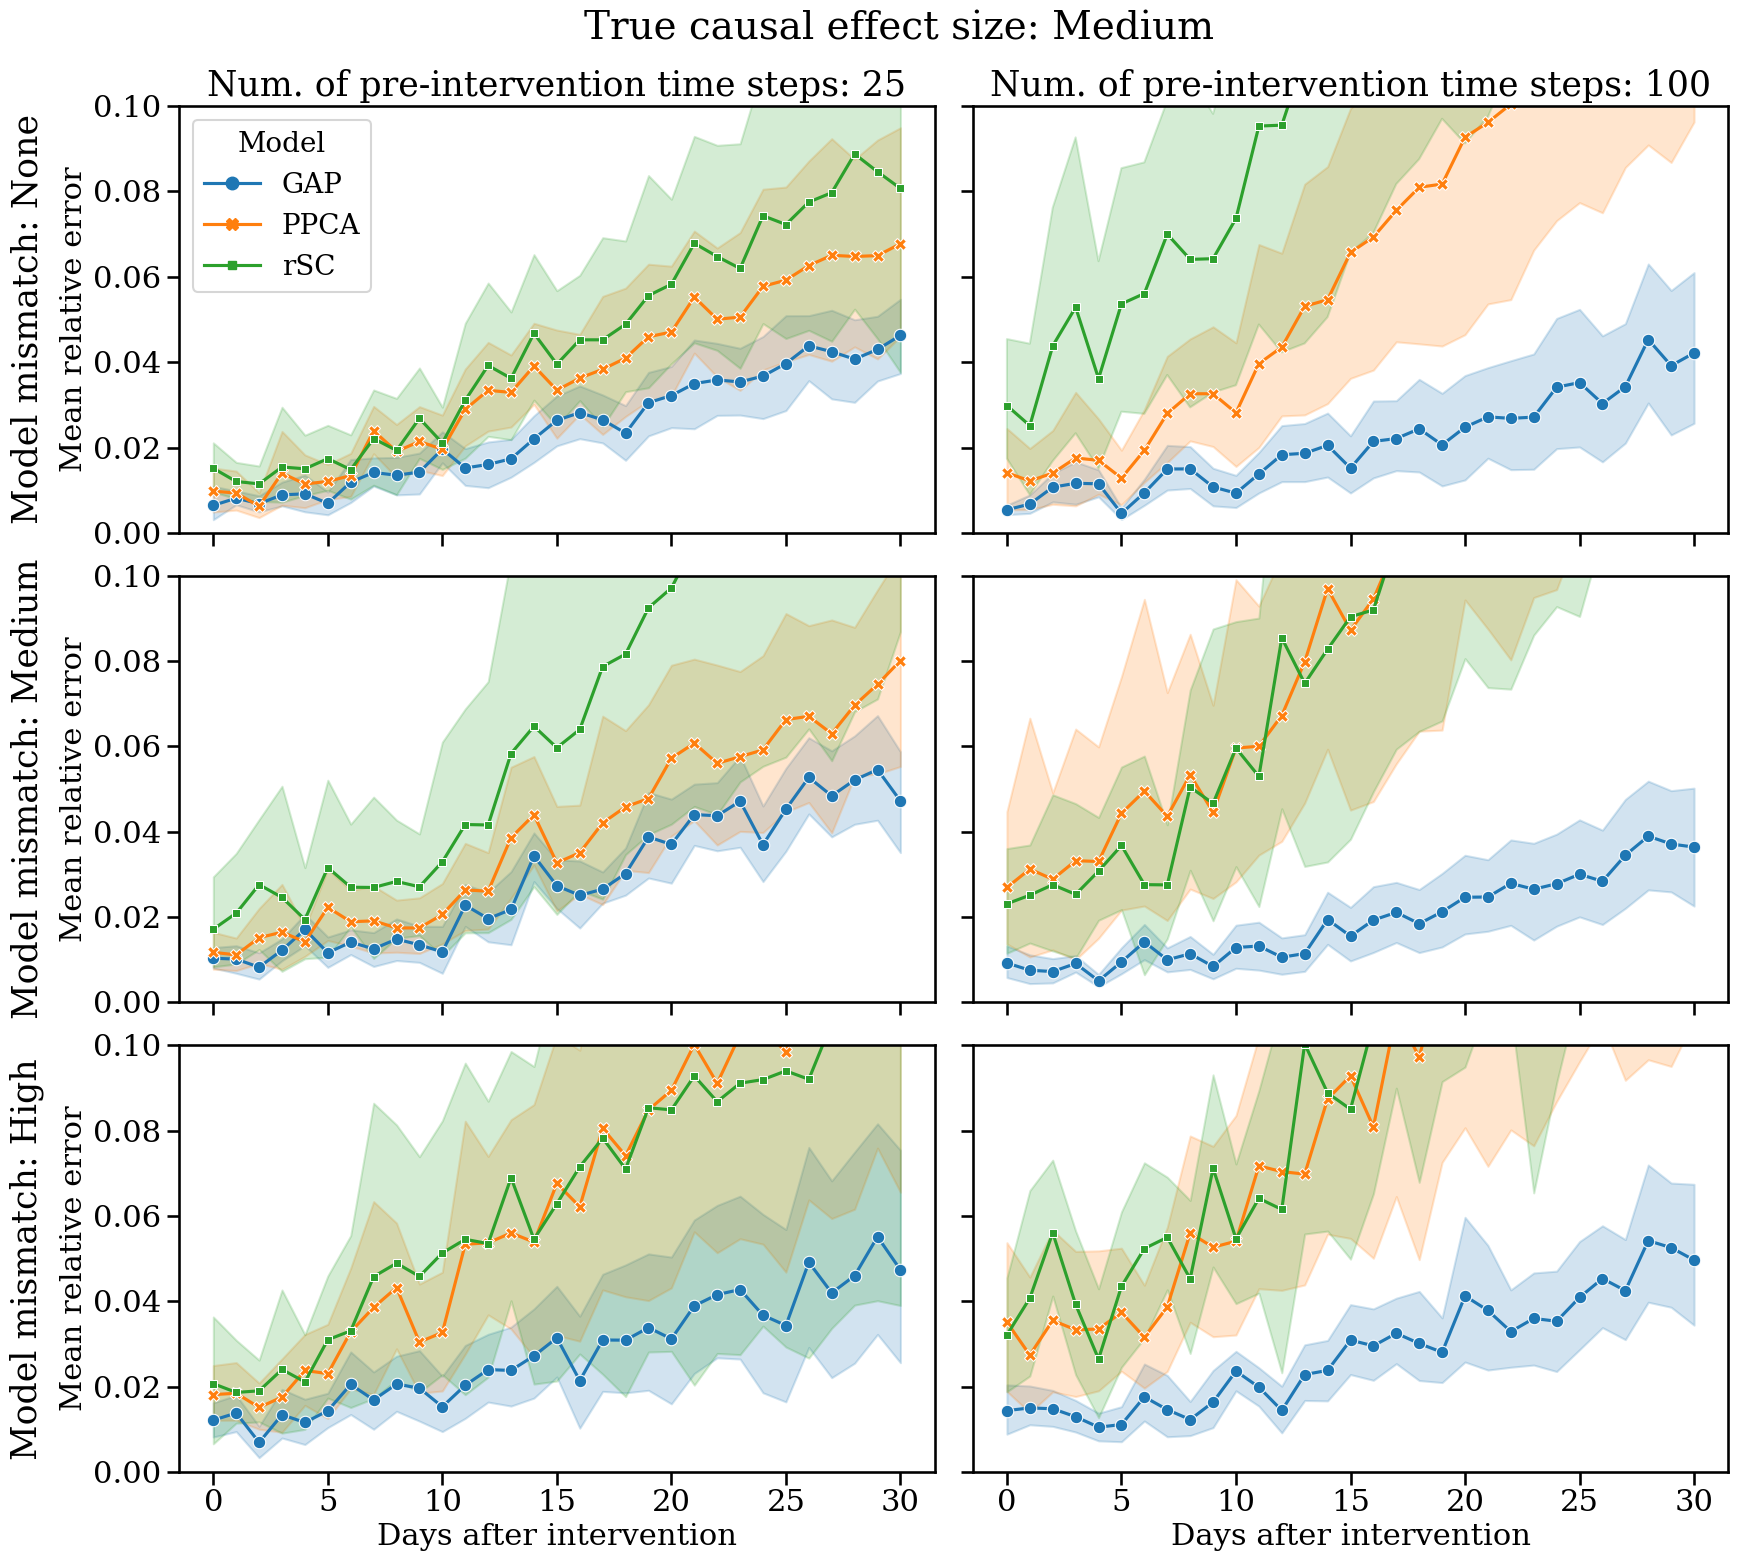

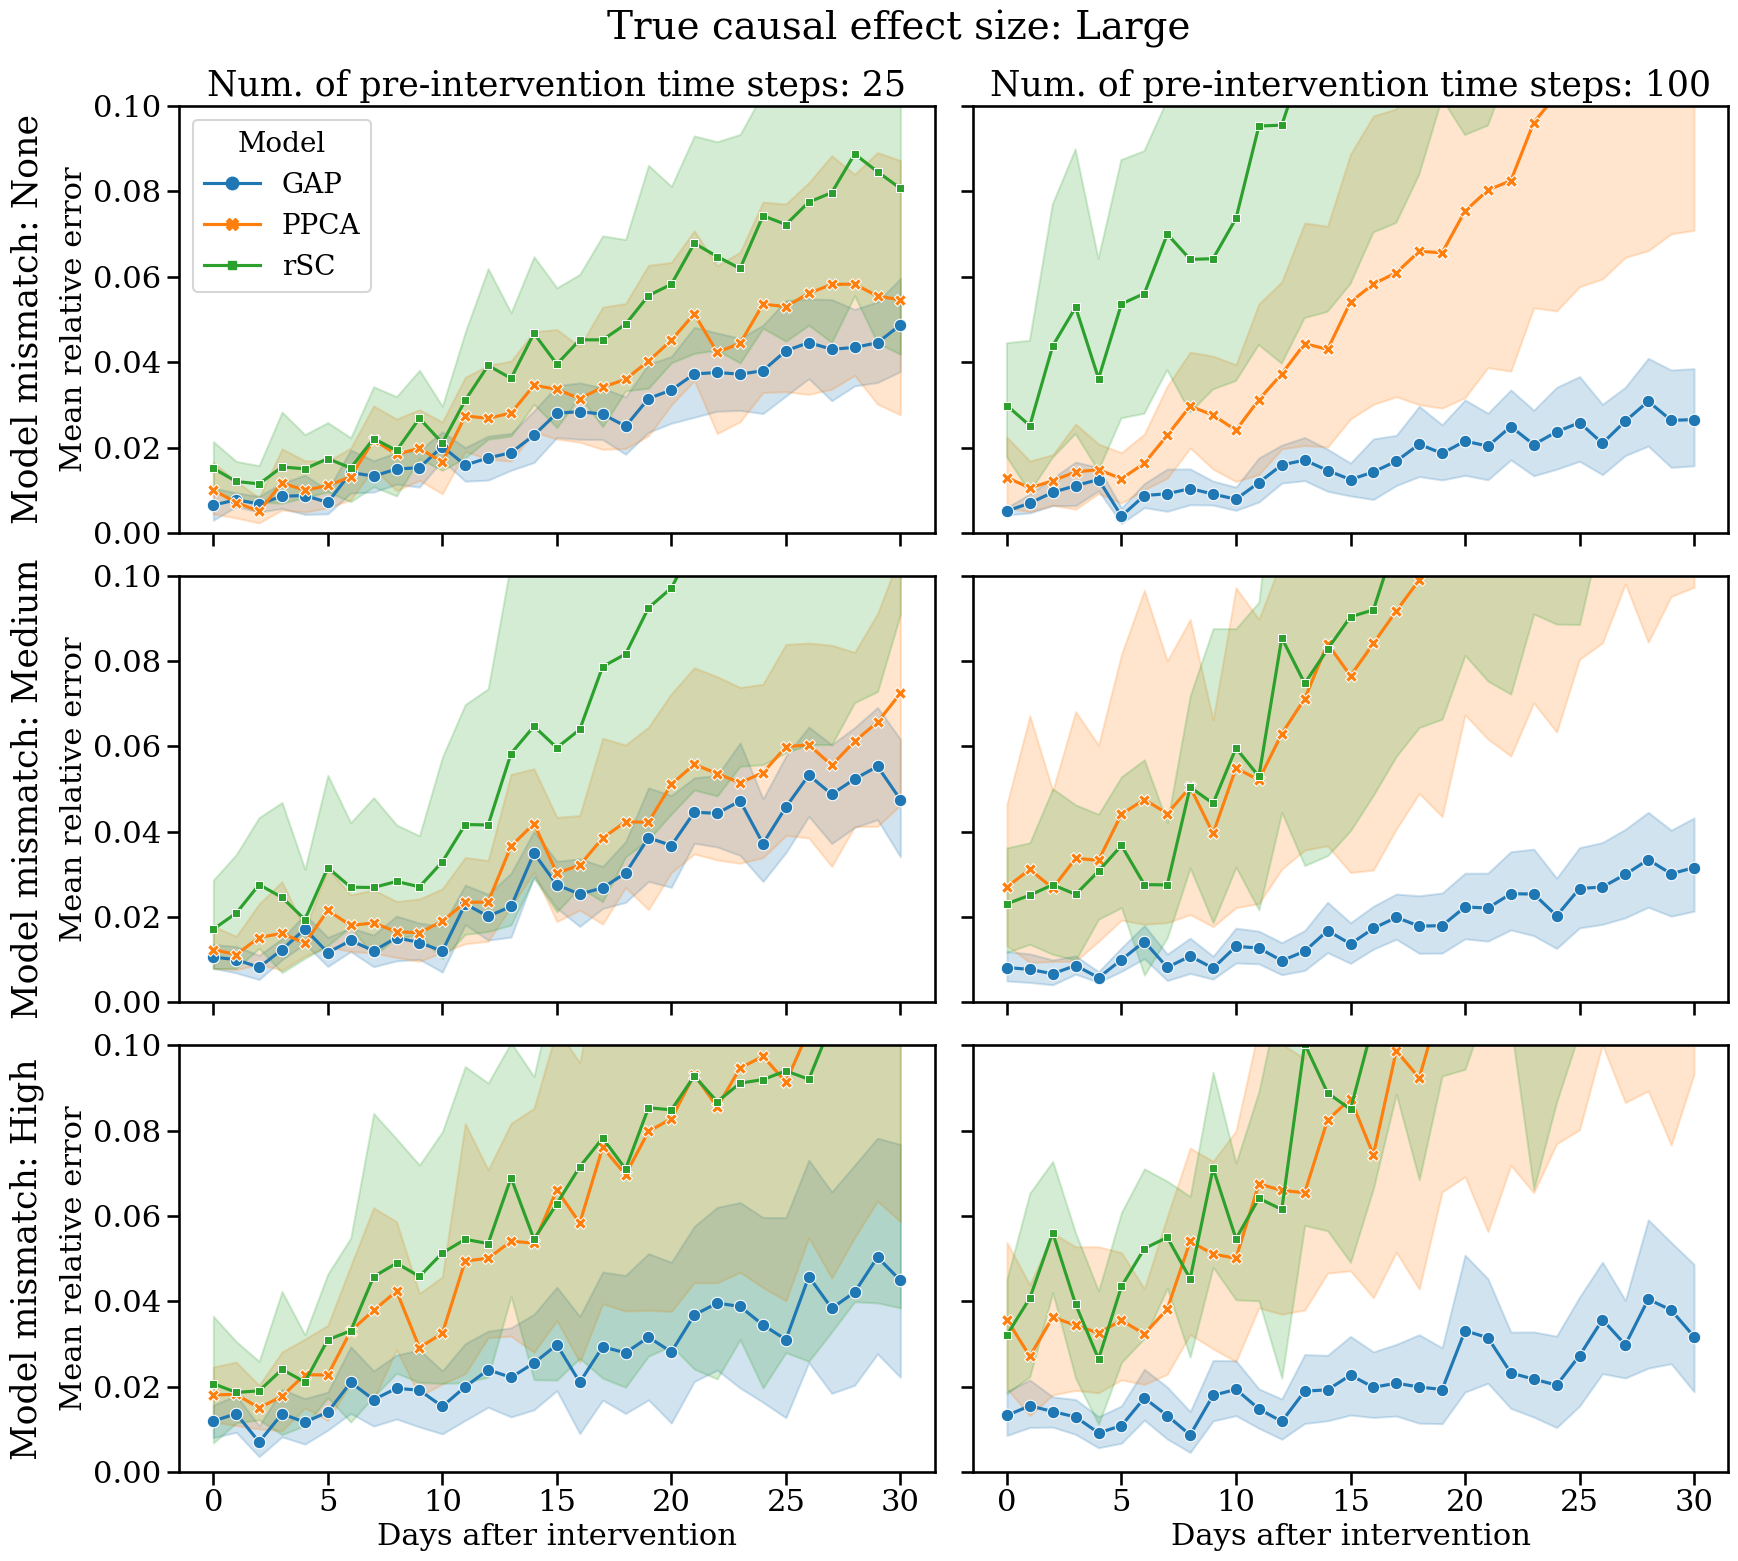

In [98]:
sns.set_context('talk')
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'

# suppress UserWarning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

FIG_DIR = Path('/home/schein/Synthetic-Control-Paper-Model/fig')
assert FIG_DIR.exists()

num = 0
for alpha, effect_size in zip([250, 500, 100000], ['Small', 'Medium', 'Large']):
# for alpha in [100000]:
    for latent_dim in [10]:
        if num >= 1:
            continue
        
        # three subplots that share 6 axis
        fig, axs = plt.subplots(3, 2, figsize=(18, 16), sharey=True, sharex=True)
        for row, (model_mismatch_p, model_mismatch_level) in enumerate(zip([0.0, 0.5, 1.0], ['None', 'Medium', 'High'])):
            for col, n_pre in enumerate([25, 100]):
                ax = axs[row, col]
                sub_df = errors_df[(errors_df['alpha'] == alpha) & 
                                    (errors_df['model_mismatch_p'] == model_mismatch_p) &
                                    (errors_df['n_pre'] == n_pre) &
                                    (errors_df['latent_dim'] == latent_dim)].copy()
            
                # sort by model
                sub_df = sub_df.sort_values('model')
                sns.lineplot(data=sub_df[(errors_df['days_after_intervention'] <= 30)],
                            x='days_after_intervention', 
                            y='mre', 
                            hue='model', 
                            errorbar=('ci', 95),
                            #  errorbar='sd',
                            #  err_style="bars",
                            # # add caps to error bars
                            #  err_kws={'capsize': 5, 'capthick': 2}
                            style='model',
                            markers=True,
                            dashes=False,
                            ax=ax
                            )
                ax.set_ylim(0, 0.1)
                ax.set_ylabel('Mean relative error', fontsize=22)
                ax.set_xlabel('Days after intervention', fontsize=22)
                # set xticklabel fontsize
                ax.tick_params(axis='x', labelsize=22)
                # set yticklabel fontsize
                ax.tick_params(axis='y', labelsize=22)

                pad = 7
                if col == 0:
                    ax.annotate(f'Model mismatch: {model_mismatch_level}', xy=(0, 0.5), xytext=(-ax.yaxis.labelpad-pad,0),                    
                                xycoords=ax.yaxis.label, textcoords='offset points',
                                ha='right', va='center', rotation=90, fontsize=25)

                if row == 0:
                    ax.annotate(f'Num. of pre-intervention time steps: {n_pre}', xy=(0.5, 1), xytext=(0, pad),
                                xycoords='axes fraction', textcoords='offset points',
                                ha='center', va='baseline', fontsize=25)
                
                if row == 0 and col == 0:
                    # set legend
                    ax.legend(loc='upper left', title='Model', title_fontsize=20, fontsize=20)
                else:
                    ax.get_legend().remove()

            # set figure title
            fig.suptitle(f'True causal effect size: {effect_size}', fontsize=28)
            # set fig ylabel
        
        # add space between fig ylabel and ax ylabel
        plt.tight_layout()
        fig.subplots_adjust(left=0.1, top=0.92)
        # decrease vertical and horizontal space between subplots 
        plt.subplots_adjust(hspace=0.1, wspace=0.05)

        # plt.show()
        # save as pdf with no padding
        plt.savefig(FIG_DIR.joinpath(f'semi_synthetic_alpha_{alpha}_latent_dim_{latent_dim}.pdf'), format='pdf', dpi=1000, bbox_inches='tight')
        print(FIG_DIR.joinpath(f'semi_synthetic_alpha_{alpha}_latent_dim_{latent_dim}.pdf'))
        plt.savefig(SYNTH_SUPDIR.joinpath(f'counterfactual_errors_alpha_{alpha}_latent_{latent_dim}.pdf'), format='pdf', dpi=1000)
        # num += 1




In [14]:
sub_df['model']

29524     GAP
57536     GAP
57535     GAP
57534     GAP
57533     GAP
         ... 
164604    rSC
164605    rSC
164606    rSC
164630    rSC
164703    rSC
Name: model, Length: 2460, dtype: object

In [23]:
SYNTH_SUPDIR = Path('/net/projects/schein-lab/jshou/synth_dat/')
counterfactual_files = list(SYNTH_SUPDIR.walkfiles('*counterfactuals.npy'))
counterfactual_files

[Path('/net/projects/schein-lab/jshou/synth_dat/Minnesota/model_mismatch_p_50/alpha_250/seed_617/results/PPCA/latent_dim_5/model_seed_617/counterfactuals.npy'),
 Path('/net/projects/schein-lab/jshou/synth_dat/Minnesota/model_mismatch_p_50/alpha_250/seed_617/results/PPCA/latent_dim_5/model_seed_781/counterfactuals.npy'),
 Path('/net/projects/schein-lab/jshou/synth_dat/Minnesota/model_mismatch_p_50/alpha_250/seed_617/results/PPCA/latent_dim_10/model_seed_781/counterfactuals.npy'),
 Path('/net/projects/schein-lab/jshou/synth_dat/Minnesota/model_mismatch_p_50/alpha_250/seed_617/results/PPCA/latent_dim_10/model_seed_617/counterfactuals.npy'),
 Path('/net/projects/schein-lab/jshou/synth_dat/Minnesota/model_mismatch_p_50/alpha_250/seed_617/results/PPCA/latent_dim_15/model_seed_781/counterfactuals.npy'),
 Path('/net/projects/schein-lab/jshou/synth_dat/Minnesota/model_mismatch_p_50/alpha_250/seed_617/results/PPCA/latent_dim_15/model_seed_617/counterfactuals.npy'),
 Path('/net/projects/schein-la

In [12]:
import sys, os
from tslib.src import tsUtils
from tslib.src.synthcontrol.syntheticControl import RobustSyntheticControl
from tslib.tests import testdata

TEAM = 'Indianapolis'
total_pivot, intervention_t, train_pivot, test_pivot = load_team_data(TEAM, return_split=True)
all_outcomes_TN = total_pivot.values
n_timesteps, n_counties = all_outcomes_TN.shape

rscModel = RobustSyntheticControl(seriesToPredictKey='Stadium_County', 
                                  kSingularValuesToKeep=10, 
                                  M=len(train_pivot), 
                                  probObservation=1.0, 
                                  modelType='svd', 
                                  svdMethod='numpy', 
                                  otherSeriesKeysArray=[col for col in train_pivot.columns if col != 'Stadium_County'])

rscModel.fit(train_pivot)
rsc_counterfactual_pred = test_pivot.values[:, :-1] @ rscModel.model.weights



In [14]:
rscModel.model.weights.shape

(83,)

In [26]:
SYNTH_DAT_DIR = Path('/net/projects/schein-lab/jshou/synth_dat/new_dat_nov_20_2023')
list(SYNTH_DAT_DIR.walkfiles('*rSC*counterfactuals.npy'))

[]

In [24]:
test_pivot.values[:, :-1] @ rscModel.model.weights

array([20724.31773673, 20763.19485972, 20808.66478744, 20848.1718987 ,
       20878.36809442, 20953.86656178, 20935.78904109, 20969.90349667,
       21032.52957451, 21083.68781141, 21061.34825386, 21119.59976058,
       21210.53013411, 21171.84814511, 21206.0050741 , 21245.59688242,
       21352.57307191, 21273.9620967 , 21281.43452702, 21400.96250094,
       21607.46850307, 21600.30545157, 21650.28601256, 21788.73920787,
       21884.24384482, 21985.05666704, 22332.52584389, 22527.4427204 ,
       22651.93033342, 22824.37485609, 22960.66621049, 23104.11504315,
       23297.70913091, 23507.13393078, 23892.72802822, 24108.72650811,
       24372.73748642, 24495.43179357, 24644.40776632, 24928.13558246,
       25414.78428379, 25977.75476682, 26125.31292767, 26484.40068742,
       27054.41790146, 27424.15130852, 28075.65348452, 28591.55650799,
       29383.64225443, 29745.91968689, 30412.70735274, 31292.69491007,
       31519.59218111, 32445.22598653, 33134.85889984, 34006.78216169,
      

In [25]:
test_pivot.values[:, -1]

array([20868., 20915., 21001., 21105., 21238., 21367., 21493., 21574.,
       21673., 21735., 21843., 21953., 22122., 22287., 22454., 22512.,
       22612., 22732., 22862., 23040., 23211., 23351., 23487., 23686.,
       23785., 24026., 24208., 24464., 24584., 24738., 24871., 25079.,
       25324., 25565., 25863., 26043., 26227., 26427., 26620., 26979.,
       27279., 27627., 27861., 28165., 28446., 28839., 29219., 29621.,
       30171., 30597., 30956., 31495., 32204., 33135., 33752., 34807.,
       35590., 36180., 37048., 37726., 38501., 39300., 40035., 40974.,
       41508., 42131., 42819., 43569., 44364., 44972., 45550., 46309.,
       47064., 47945., 48921., 50080., 51069., 52056., 52919., 53696.,
       54387., 55399., 56430., 57361., 58276., 59116., 59718., 60670.,
       61563., 62555., 63190., 64119., 64739., 65255., 65901., 66703.,
       67491., 68025., 68327., 68627., 69335., 69987., 70801.])